# Bayesian Full-Field Inference

The ultimate goal of differentiable forward modeling is **inference**: given an observed convergence map, what are the initial conditions and cosmological parameters that produced it?

This notebook uses the probabilistic modeling layer to:
1. Define the forward model as a NumPyro probabilistic model
2. Generate mock observations
3. Sample the posterior using MCMC (via `batched_sampling`)
4. Analyze posterior samples

The full-field approach jointly infers the 3D initial conditions field and cosmological parameters, using the differentiable pipeline (IC -> LPT -> PM -> lensing) as the likelihood.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.97'
os.environ['JAX_PLATFORM_NAME'] = 'cpu'  # or 'cpu' if you want to run on CPU

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpyro.distributions as dist
from numpyro.handlers import condition, seed, trace
import fwd_model_tools as ffi

/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
ERROR:2026-02-22 22:09:00,094:jax._src.xla_bridge:491: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 489, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/j

## Define Configuration

The `Configurations` dataclass bundles all settings for the forward model and inference:
- Source redshift distributions (`nz_shear`)
- Integration parameters (`t0`, `t1`, `dt0`)
- Cosmological priors
- Lensing method and geometry

In [3]:
# Source redshift distributions
nz_sources = ffi.io.get_stage3_nz_shear()

In [4]:
priors = {
    "Omega_c": ffi.sampling.PreconditionnedUniform(0.1, 0.5),
    "sigma8": ffi.sampling.PreconditionnedUniform(0.6, 1.0),
}

mesh_size = (4 , 4 , 4)
box_size = (250.0, 250.0, 250.0)
nside = 4
cosmo = jc.Planck18()

config = ffi.ppl.Configurations(
    mesh_size=mesh_size,
    box_size=box_size,
    nside=nside,
    density_plane_smoothing=0.0,
    nz_shear=nz_sources,
    fiducial_cosmology=jc.Planck18,
    sigma_e=0.26,
    priors=priors,
    t0=0.1,
    dt0=0.1,
    t1=1.0,
    geometry="spherical",
    lensing="born",
    number_of_shells=4,
    lpt_order=1,
)

## Create Template Field

The template field provides the metadata (mesh size, box size, observer position, resolution) for the forward model. Its actual array values are not used -- only the shape and geometry matter.

In [5]:
key = jax.random.PRNGKey(42)


init_field = ffi.gaussian_initial_conditions(
    key, mesh_size, box_size,
    cosmo=cosmo,
    nside=nside,
)

print(f"Template mesh: {init_field.mesh_size}")
print(f"Template box: {init_field.box_size}")

Template mesh: (4, 4, 4)
Template box: (250.0, 250.0, 250.0)


## Build and Test the Forward Model

`make_full_field_model` returns a JIT-compiled function that maps (cosmology, initial_conditions) to (kappa_maps, lightcone, linear_field). We test it with the fiducial cosmology to generate mock data.

Mock kappa shape: (4, 192)
Mock lightcone shape: (4, 192)


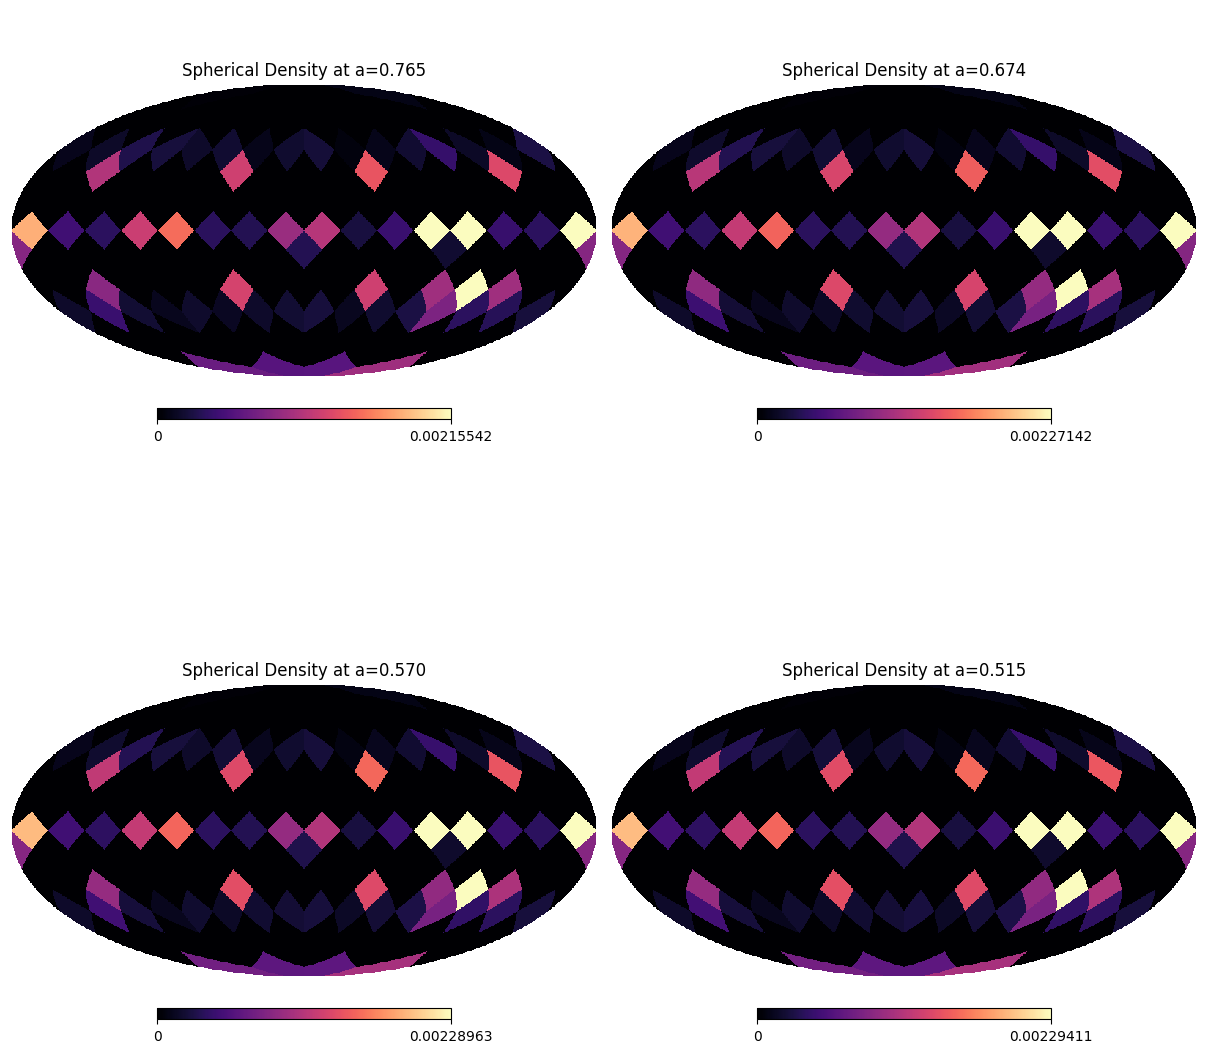

In [6]:
forward_model = ffi.probabilistic_models.make_full_field_model(config=config)

# Generate mock observation
kappa_mock, lightcone_mock = forward_model(cosmo, init_field)

print(f"Mock kappa shape: {kappa_mock.shape}")
print(f"Mock lightcone shape: {lightcone_mock.shape}")
kappa_mock.show(ncols=2)

## Build Probabilistic Model

`full_field_probmodel` wraps the forward model in a NumPyro model that:
1. Samples cosmological parameters from the priors
2. Samples the initial conditions from a standard normal
3. Runs the forward model
4. Adds Gaussian noise based on `sigma_e` and galaxy density

In [7]:
prob_model = ffi.probabilistic_models.full_field_probmodel(config)

In [8]:
model_trace = trace(seed(prob_model, 0)).get_trace()

omega_c = model_trace['Omega_c']['value']
sigma8 = model_trace['sigma8']['value']
init_field = model_trace['initial_conditions']['value']

In [9]:
init_params = {
    'Omega_c': omega_c,
    'sigma8': sigma8,
    'initial_conditions': init_field}

conditioned_model = condition(prob_model, data={f'kappa_{i}': model_trace[f'kappa_{i}']['value'] for i in range(config.number_of_shells)})

## Sampling with batched_sampling

`batched_sampling` runs MCMC in checkpointed batches. Each batch is saved to disk, allowing long runs to be resumed. It supports:
- **Backend**: `"numpyro"` (pure NumPyro) or `"blackjax"` (BlackJAX kernels via NumPyro)
- **Sampler**: `"NUTS"` or `"HMC"` (numpyro), or `"MCLMC"` (blackjax only)
- **Batching**: `batch_count` controls how many batches to run sequentially

For this demo we use a very small number of samples.

In [10]:
output_path = "output/demo_inference"
sample_key = jax.random.PRNGKey(0)

# Small demo run
ffi.sampling.batched_sampling(
    conditioned_model,
    init_params=init_params,
    path=output_path,
    rng_key=sample_key,
    num_warmup=1,
    num_samples=2,
    batch_count=1,
    sampler="NUTS",
    backend="numpyro",
    progress_bar=True,
    save_callback=ffi.ppl.sample2catalog(config),
)

warmup: 100%|██████████| 1/1 [01:09<00:00, 69.86s/it, 1 steps of size 2.34e+00. acc. prob=0.00]


Sampling batch 1/1 using NUTS with numpyro...
At sample batch 1, total samples so far: 0


sample: 100%|██████████| 2/2 [01:09<00:00, 34.85s/it, 1 steps of size 2.34e+00. acc. prob=0.00]


Saving batch 1 samples and state...


Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

No kappa samples found, skipping kappa catalog saving.


In [14]:
import datasets
ds = datasets.load_from_disk(f"{output_path}/samples_0")

FileNotFoundError: Directory output/demo_inference/samples_0 is neither a `Dataset` directory nor a `DatasetDict` directory.

In [ ]:
## Verify saved catalogs
import glob

ic_files = sorted(glob.glob(f"{output_path}/ic/initial_*.parquet"))
field_files = sorted(glob.glob(f"{output_path}/fields/fields_*.parquet"))

print(f"IC parquet files:     {ic_files}")
print(f"Fields parquet files: {field_files}")

if ic_files:
    ic_catalog = ffi.io.Catalog.from_parquet(ic_files[0])
    print(f"\nIC catalog: {len(ic_catalog)} entries")
    print(f"  Field shape: {ic_catalog.field[0].shape}")
    print(f"  Status:      {ic_catalog.field[0].status}")

if field_files:
    kappa_catalog = ffi.io.Catalog.from_parquet(field_files[0])
    print(f"\nKappa catalog: {len(kappa_catalog)} entries")
    print(f"  Field shape:    {kappa_catalog.field[0].shape}")
    print(f"  Status:         {kappa_catalog.field[0].status}")
    print(f"  z_sources:      {kappa_catalog.field[0].z_sources}")